# Analysis of Hawaii Climate

In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [8]:
# declare Base
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [9]:
# view all of the classes (tables)
Base.classes.keys()


['measurement', 'station']

In [10]:
# save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# show columns in table

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# show columns in table

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# create session
session = Session(engine)


# Exploratory Precipitation Analysis

In [14]:
# find the most recent date in the data set.

most_recent_date_str = session.query(func.max(Measurement.date)).first()[0]

most_recent_date_str

'2017-08-23'

In [15]:
# convert string date to datetime date
most_recent_date = dt.datetime.strptime(most_recent_date_str, "%Y-%m-%d").date()


In [16]:
# retrieve the last 12 months of precipitation data and plot the results. 
# starting from the most recent data point in the database. 

# calculate the date one year from the last date in data set.
year_prior = most_recent_date - dt.timedelta(days=365)

# retrieve the date and precipitation scores
statement = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_prior).statement

# save the query results in a dataframe
df_prcp = pd.read_sql(statement, session.bind)

# Sort the dataframe by date and set date as index
df_prcp.sort_values(by='date', ascending=True, inplace=True)
df_prcp.set_index("date", inplace=True)

#drop NaN
df_prcp.dropna(how='any', inplace=True)

df_prcp.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


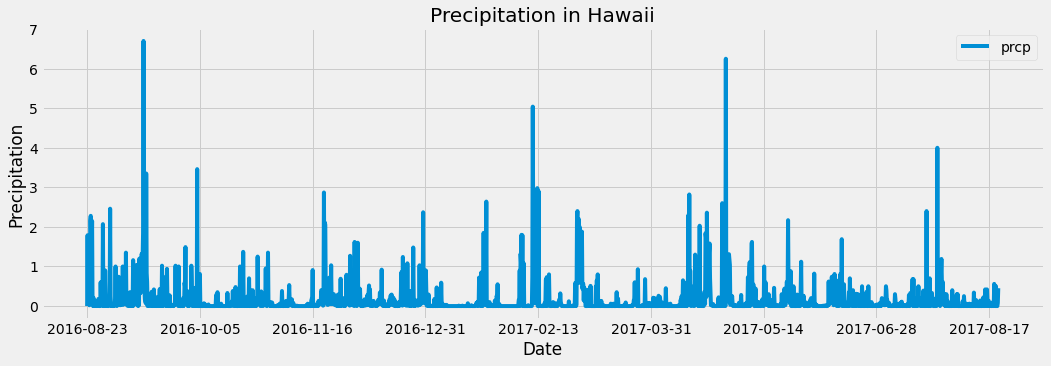

In [17]:
# plot the data
fig, ax = plt.subplots(figsize=(16,5))
df_prcp.plot(kind='line', ax=ax)
ax.set(title="Precipitation in Hawaii",
       xlabel="Date",
       ylabel="Precipitation");


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# calculate the total number stations in the dataset
station_count_measurement = session.query(func.count(Measurement.station.distinct())).first()

station_count_station = session.query(func.count(Station.station.distinct())).first()

print(f"There are {str(station_count_measurement[0])} stations in the 'measurement' table and {str(station_count_station[0])} stations in the 'station' table.")

There are 9 stations in the 'measurement' table and 9 stations in the 'station' table.


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

statement = session.query(Station.station, 
                          Station.name, 
                          func.count(Measurement.id).label("measurement_count")
                         ).join(Measurement, Station.station == Measurement.station).group_by(Station.station, 
                                                                                              Station.name
                                                                                             ).statement

df_station_count = pd.read_sql(statement, session.bind)
df_station_count.sort_values(by="measurement_count", ascending=False, inplace=True)
df_station_count.set_index("station", inplace=True)


df_station_count.head()

,name,measurement_count
station,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [21]:
most_active_station = df_station_count.index[0]

most_active_station

'USC00519281'

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
statement = session.query(Measurement.station, 
                          func.min(Measurement.tobs).label("temp_low"),
                          func.max(Measurement.tobs).label("temp_high"),
                          func.avg(Measurement.tobs).label("temp_avg")
                         ).filter(Measurement.station == most_active_station).group_by(Measurement.station).statement

df_station_temp = pd.read_sql(statement, session.bind)
df_station_temp.set_index('station', inplace=True)

df_station_temp

,temp_low,temp_high,temp_avg
station,,,
USC00519281,54.0,85.0,71.663781


In [23]:
# query the last 12 months of temperature observation data for this station
# retrieve the data and temp observations
statement = session.query(Measurement.date, 
                          Measurement.station, 
                          Measurement.tobs, 
                         ).filter(Measurement.date >= year_prior, 
                                  Measurement.station == most_active_station
                                 ).statement

# save the query results in a dataframe
df_station_temp_year = pd.read_sql(statement, session.bind)

# Sort the dataframe by date and set date as index
df_station_temp_year.sort_values(by='date', ascending=True, inplace=True)
df_station_temp_year.set_index("date", inplace=True)

#drop NaN
df_station_temp_year.dropna(how='any', inplace=True)

df_station_temp_year.head()

,station,tobs
date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0


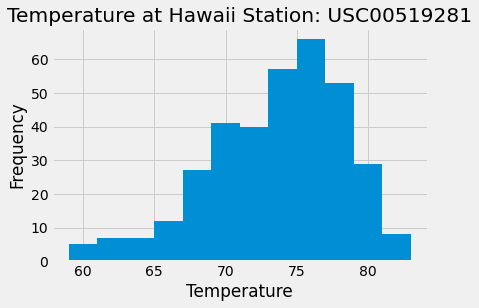

In [24]:
# plot the results as a histogram

fix, ax = plt.subplots()
df_station_temp_year.tobs.hist(ax=ax, bins=12)
ax.set(title=f'Temperature at Hawaii Station: {most_active_station}',
       xlabel='Temperature',
       ylabel="Frequency");


# Close session

In [42]:
# Close Session
session.close()